# Extract background features

Image -> Grayscale -> cropped into patches -> Find features to characterize the background features. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys, os

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
import pandas
from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *


Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [9]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 224
patch_half_size = patch_size / 2
stride = 56
# Crop images
# 
# crop_x_min = 9000
# crop_x_max = 10500
# crop_y_min = 3000
# crop_y_max = 4500

# Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Whole
crop_x_min = 0
crop_y_min = 0
_, _, crop_y_max, crop_x_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)

crop_image_width = crop_y_max - crop_y_min
crop_image_height = crop_x_max - crop_x_min

def get_filename(define_list):
    """
    get_finelname(list_of_definition_component): return a string concaining filename definition, seperated by '_' 
    """
    filename_head = ''
    for filename_element in map(str,define_list):
        filename_head = filename_head + filename_element + '_'
    return filename_head

patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;


save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Extract_background_features/'
if os.path.isdir(save_folder_path):
    sys.stderr.write('Folder already exists.')
else:
    os.makedirs(save_folder_path)
    sys.stderr.write('Folder created.')

Folder already exists.

In [182]:
# Set examine section number range and download from S3 if not available
img_filename = []
secIndexList = range(200, 201)

for tempIndex1 in range(len(secIndexList)):
    img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))
    if os.path.isfile(img_filename[tempIndex1]):
        sys.stderr.write('Image files are already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempIndex1])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            continue           


Image files are already available. 


In [ ]:
im_cropped = []
for imIndex in img_filename:
# for imIndex in [img_filename[0]]:
     im_cropped.append(img_as_ubyte(rgb2gray(imread(imIndex)[crop_x_min:crop_x_max, crop_y_min:crop_y_max])))
    
im_cropped_h, im_cropped_w = im_cropped[0].shape[:2]

In [6]:
# display_image(imread(img_filename[0]))

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

In [11]:
option_rescale_grayscale = True
option_inverse_color = False
secIndex = 0

if option_rescale_grayscale:
    tempImage = im_cropped[secIndex]
    vmin = np.percentile(tempImage, 0)
    vmax = np.percentile(tempImage, 100)
    tempImage = (tempImage - vmin) / (vmax - vmin)
    tempImage = np.maximum(np.minimum(tempImage, 1), 0)
    tempImage = img_as_ubyte(tempImage)
    if option_inverse_color:
        tempImage = 255 - img_as_ubyte(tempImage)
else:
    tempImage = im_cropped[secIndex]

In [20]:
'Normalized rescaled grayscale histrogram of cropped original image\n Image size: {} * {}'.format(crop_image_height, crop_image_width)

Normalized rescaled grayscale histrogram of cropped original image
 Image size: 11936 * 15520


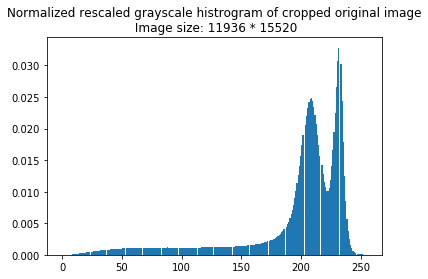

In [21]:
plt.hist(tempImage.flatten(), bins=256, normed=True);
plt.title('Normalized rescaled grayscale histrogram of cropped original image\n Image size: {} * {}'.format(crop_image_height, crop_image_width))
plt.show()

In [15]:
grayscale_AccPtl = [(percentile, np.percentile(tempImage.flatten(), percentile)) for percentile in range(0,100,5)]
grayscale_AccPtl

[(0, 0.0),
 (5, 76.0),
 (10, 123.0),
 (15, 163.0),
 (20, 185.0),
 (25, 195.0),
 (30, 199.0),
 (35, 202.0),
 (40, 206.0),
 (45, 208.0),
 (50, 210.0),
 (55, 212.0),
 (60, 214.0),
 (65, 218.0),
 (70, 223.0),
 (75, 227.0),
 (80, 229.0),
 (85, 231.0),
 (90, 234.0),
 (95, 236.0)]

# Global Threshold - Otsu

In [37]:
from skimage.filters import threshold_otsu
otsu_thresh = threshold_otsu(tempImage)
tempImage_BW = tempImage <= otsu_thresh

In [38]:
# Detected area
detected_total_area = np.sum(tempImage_BW)
detected_total_area_ratio = detected_total_area / float(crop_image_height * crop_image_width)
print('Total detected area ratio is %f' %detected_total_area_ratio)

Total detected area ratio is 0.133659


In [49]:
# Get image matrix of each patch 
patches = [tempImage[y - patch_half_size : y + patch_half_size, x - patch_half_size : x + patch_half_size].copy() for x, y in patch_center_pixel_location]
patch_area = patch_size ** 2
patch_detected_area_ratio = np.array([np.sum(tempPatches <= otsu_thresh)/float(patch_area) for tempPatches in patches])

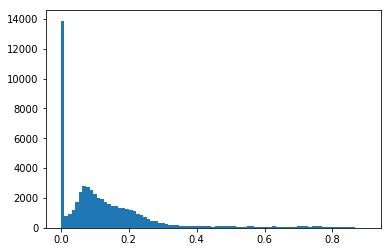

In [50]:
plt.hist(patch_detected_area_ratio,85);

In [107]:
patch_density_classes = {}
for tempTH in np.arange(0,100,10):
    temp_ratio = (patch_detected_area_ratio > tempTH/float(100)) * (patch_detected_area_ratio <= tempTH/float(100) + 0.1 )
    temp_ratio = np.where(temp_ratio == True)[0]
    
    
# patch_rL08_index = patch_detected_area_ratio > 0.8
# patch_rL08_index = np.where(patch_rL08_index == True)[0]
# patch_rL08_index = patch_rL08_index.tolist()

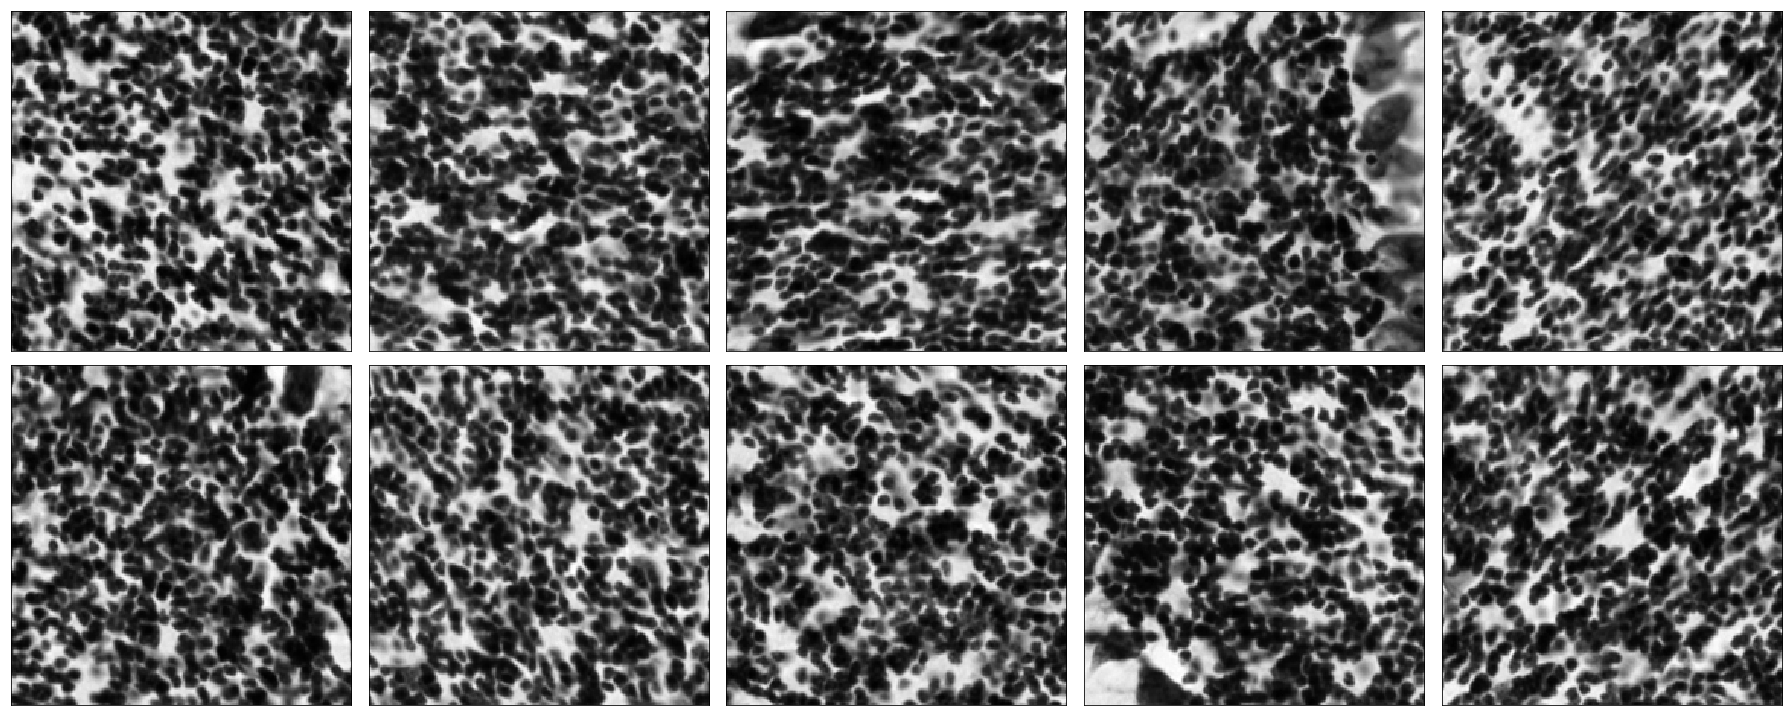

In [187]:
viz_index = np.random.choice(patch_density_classes[80],10).tolist()
viz_patches_list = [patches[index1] for index1 in viz_index]
display_images_in_grids(viz_patches_list, nc=5, cmap=plt.cm.gray)

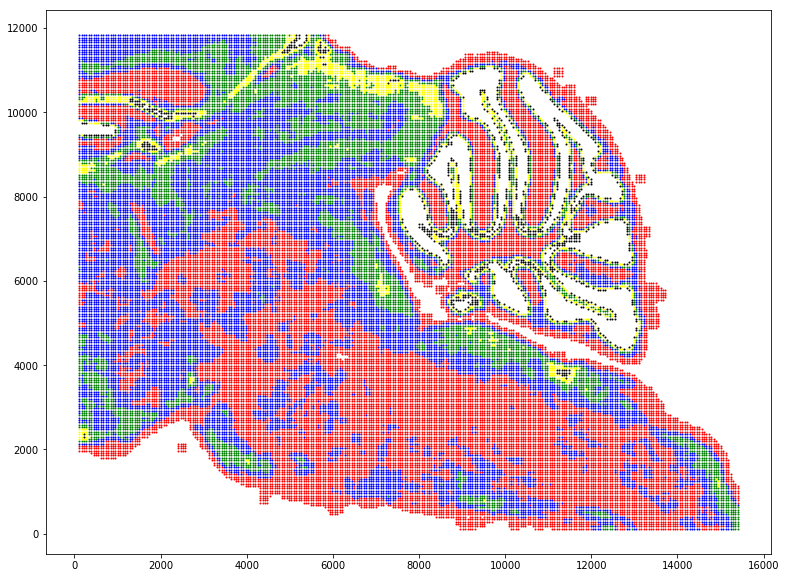

In [188]:
aspectiao = crop_image_width/float(crop_image_height)
plt.figure(figsize=(10*aspectiao, 10))
viz_patches_centLoc_list = patch_center_pixel_location[patch_density_classes[0]]
plt.scatter(viz_patches_centLoc_list[:,0],crop_image_height - viz_patches_centLoc_list[:,1],color='red', s=1);
plt.hold
viz_patches_centLoc_list = patch_center_pixel_location[patch_density_classes[10]]
plt.scatter(viz_patches_centLoc_list[:,0],crop_image_height - viz_patches_centLoc_list[:,1],color='blue', s=1);
plt.hold
viz_patches_centLoc_list = patch_center_pixel_location[patch_density_classes[20]]
plt.scatter(viz_patches_centLoc_list[:,0],crop_image_height - viz_patches_centLoc_list[:,1],color='green', s=1);
plt.hold
viz_patches_centLoc_list = patch_center_pixel_location[patch_density_classes[30]]
plt.scatter(viz_patches_centLoc_list[:,0],crop_image_height - viz_patches_centLoc_list[:,1],color='yellow', s=1);
plt.hold
viz_patches_centLoc_list = patch_center_pixel_location[patch_density_classes[40]]
plt.scatter(viz_patches_centLoc_list[:,0],crop_image_height - viz_patches_centLoc_list[:,1],color='black', s=1);

# Background Features

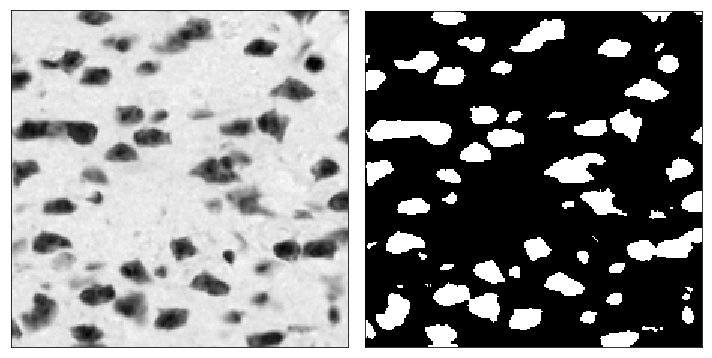

In [194]:
tempPatch = patches[0];
display_images_in_grids([tempPatch, tempPatch <= otsu_thresh], nc=2, cmap=plt.cm.gray)

In [190]:
from scipy import ndimage as ndi

In [200]:
distance_im = ndi.distance_transform_bf(tempPatch)
print np.max(distance_im), np.min(distance_im)


1.34078079299e+154 1.34078079299e+154


# To-do List
1. Write a function to visualize the score map for each features
2. Find feature to characterize hole/ fiber
    (a) downscale the image after Gaussian filter
    
3. 
